In [1]:
"""
From https://www.kaggle.com/aharless/kaggle-runnable-version-of-baris-kanber-s-lightgbm/code
"""

inpath = '../input/'
suffix = ''
outpath = ''
savepath = ''

import datetime
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os
import feather

In [2]:
nrows=      184903891-1
#train_size=  75000000
#val_size=     2500000
#offset=      75000000
#frm=nrows-offset
#to=frm+train_size

#day 8 starting from=68941878
#day 9 starts 131886953
#day 9 ends 184903889

#day 9 hour 4 starts; 144708152
#day 9 hour 4 ends; 148740842

train_size=  62945075
val_size=    53016936
offset=      68941878
frm=offset
to=frm+train_size+val_size


In [3]:
frm, to

(68941878, 184903889)

In [4]:


def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

debug=0
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')


def DO(frm, to):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }
    
    print('loading train data...')
    train_df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    train_df = train_df.iloc[frm:to]
    
    #binip = feather.read_dataframe('/kaggle1/td-cache/train_binip.feather')
    #train_df['binip'] = binip['binip'].values
    #train_df = train_df[train_df.day.isin([8, 9])]
    
    gc.collect()
    
    #train_df = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

    print('loading test data...')
    if debug:
        test_df = pd.read_csv("../input/test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = feather.read_dataframe('/kaggle1/td-cache/test_base.feather')
        
        #test_df = pd.read_csv("../input/test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

    train_df=train_df.append(test_df)
    
    del test_df
    gc.collect()
    
    print('Extracting new features...')
    #train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
    #train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
    
    gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
    train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

    print('doing nextClick')
    #predictors=[]
    
    new_feature = 'nextClick'
    filename='nextClick_%d_%d.csv'%(frm,to)

    if os.path.exists(filename):
        print('loading from save file')
        QQ=pd.read_csv(filename, header=None)[0].values
    else:
        D=2**26
        train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
            + "_" + train_df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)

        train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-t)
            click_buffer[category]= t
        del(click_buffer)
        QQ= list(reversed(next_clicks))

        if not debug:
            print('saving')
            pd.DataFrame(QQ).to_csv(filename,index=False)
            
    to_drop = [x for x in train_df.columns if x in ['epochtime','category','click_time']]
    train_df.drop(to_drop, axis=1, inplace=True)

    train_df[new_feature] = pd.Series(QQ).astype('float32')
    #predictors.append(new_feature)

    train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
    #predictors.append(new_feature+'_shift')
    
    del QQ
    gc.collect()

    train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
    train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
    train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

    print("vars and data type: ")
    train_df.info()
    
    train_df.reset_index(drop=True, inplace=True)
    feather.write_dataframe(train_df, '9671_train_from{}_to{}.feather'.format(frm, to))

    return train_df
    



In [5]:
print(datetime.datetime.now())
DO(frm, to)
print(datetime.datetime.now())

2018-04-18 15:32:59.568490
loading train data...
loading test data...
Extracting new features...
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  159
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  182197
Counting unqiue  hour  by  ['ip', 'day'] ...
X2 max value =  24
Counting unqiue  app  by  ['ip'] ...
X3 max value =  252
Counting unqiue  os  by  ['ip', 'app'] ...
X4 max value =  140
Counting unqiue  device  by  ['ip'] ...
X5 max value =  458
Counting unqiue  channel  by  ['app'] ...
X6 max value =  47
Cumulative count by  ['ip'] ...
X7 max value =  923761
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  96
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  43958
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  148098
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  34081
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  264.5
Calculating variance of  hou

,app,channel,day,device,hour,ip,is_attributed,os,X0,X1,...,X8,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour,nextClick,nextClick_shift
0,23,153,8,1,0,48240,0,13,146,0,...,54,1875,1475,285,36.791149,26.955324,0.513365,10.705830,111.0,NaN
1,13,477,8,1,0,45702,0,16,127,0,...,21,235,207,4,51.948845,75.666664,0.566051,8.500000,28.0,111.0
2,12,259,8,1,0,123214,0,13,95,0,...,23,44,256,73,67.809525,28.528540,0.265152,5.833333,4239.0,28.0
3,15,265,8,1,0,98052,0,19,116,0,...,34,669,862,184,48.291557,54.672100,0.710111,7.745763,127.0,4239.0
4,6,125,8,1,0,97903,0,18,114,0,...,24,105,66,4,53.018181,27.000000,0.333333,9.480000,86.0,127.0


In [6]:
import feather
train_df = feather.read_dataframe('9671_train_from{}_to{}.feather'.format(frm, to))

In [1]:
#import feather
#df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    

In [10]:
val_size

53016936

In [11]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)


In [14]:
def DO2(train_df, frm, to, val_size):
    target = 'is_attributed'
    predictors=['nextClick', 'nextClick_shift']
    predictors.extend(['app','device','os', 'channel', 'hour', #'day', 
                       #'binip',
                  'ip_tcount', 'ip_tchan_count', 'ip_app_count',
                  'ip_app_os_count', 'ip_app_os_var',
                  'ip_app_channel_var_day','ip_app_channel_mean_hour',
                  'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
    categorical = ['app', 'device', 'os', 'channel', 'hour', 
                   #'binip'
                  ]
    print('predictors', predictors)
    
    len_train = to - frm
    
    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))
    
    print('== va head')
    print(val_df[['day', 'hour']].head())
    
    print('== val tail')
    print(val_df[['day', 'hour']].tail())

    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.20,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }
    (bst,best_iteration) = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()

    
    #print('Plot feature importances...')
    #ax = lgb.plot_importance(bst, max_num_features=100)
    #plt.show()
    

    return bst
    

In [15]:
bst = DO2(train_df, frm, to, val_size)

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
train size:  62945075
valid size:  53016936
test size :  18790469
== va head
          day  hour
62945075    9     0
62945076    9     0
62945077    9     0
62945078    9     0
62945079    9     0
== val tail
           day  hour
115962006    9    16
115962007    9    16
115962008    9    16
115962009    9    16
115962010    9    16
Training...
preparing validation datasets


/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.97261	valid's auc: 0.965922
[20]	train's auc: 0.978569	valid's auc: 0.973752
[30]	train's auc: 0.981266	valid's auc: 0.9769
[40]	train's auc: 0.9826	valid's auc: 0.978358
[50]	train's auc: 0.98329	valid's auc: 0.979102
[60]	train's auc: 0.983704	valid's auc: 0.979522
[70]	train's auc: 0.984084	valid's auc: 0.979798
[80]	train's auc: 0.984499	valid's auc: 0.98026
[90]	train's auc: 0.984733	valid's auc: 0.980436
[100]	train's auc: 0.984969	valid's auc: 0.980666
[110]	train's auc: 0.985161	valid's auc: 0.980778
[120]	train's auc: 0.985356	valid's auc: 0.980907
[130]	train's auc: 0.985511	valid's auc: 0.981066
[140]	train's auc: 0.985658	valid's auc: 0.981119
[150]	train's auc: 0.985773	valid's auc: 0.981204
[160]	train's auc: 0.985878	valid's auc: 0.981279
[170]	train's auc: 0.985972	valid's auc: 0.981305
[180]	train's auc: 0.986077	valid's auc: 0.98137
[190]	train's auc: 0.986154	valid's auc: 0.981282
[200]

Plot feature importances...


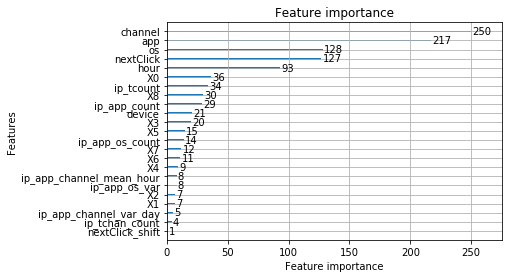

In [16]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100)
plt.show()

In [17]:
len(train_df)

134752480

In [30]:
def predict(train_df, frm, to, bst, best_iteration=-1):
    len_train = to - frm    
    test_df = train_df[len_train:]
    
    print("Predicting...")
    click_ids = pd.read_csv('../input/test.csv', usecols=['click_id'])['click_id'].values
    
    sub = pd.DataFrame()    
    sub['click_id'] = click_ids
        
    gc.collect()
    
    predictors=['nextClick', 'nextClick_shift']
    predictors.extend(['app','device','os', 'channel', 'hour', #'day', 
                       #'binip',
                  'ip_tcount', 'ip_tchan_count', 'ip_app_count',
                  'ip_app_os_count', 'ip_app_os_var',
                  'ip_app_channel_var_day','ip_app_channel_mean_hour',
                  'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
    
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
                            
    print("writing...")
    sub.to_csv('tmp.csv', index=False, float_format='%.9f')
    print("done...")    

In [31]:
predict(train_df, frm, to, bst, 181)

Predicting...
writing...
done...


In [ ]:
"""
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.97261	valid's auc: 0.965922
[20]	train's auc: 0.978569	valid's auc: 0.973752
[30]	train's auc: 0.981266	valid's auc: 0.9769
[40]	train's auc: 0.9826	valid's auc: 0.978358
[50]	train's auc: 0.98329	valid's auc: 0.979102
[60]	train's auc: 0.983704	valid's auc: 0.979522
[70]	train's auc: 0.984084	valid's auc: 0.979798
[80]	train's auc: 0.984499	valid's auc: 0.98026
[90]	train's auc: 0.984733	valid's auc: 0.980436
[100]	train's auc: 0.984969	valid's auc: 0.980666
[110]	train's auc: 0.985161	valid's auc: 0.980778
[120]	train's auc: 0.985356	valid's auc: 0.980907
[130]	train's auc: 0.985511	valid's auc: 0.981066
[140]	train's auc: 0.985658	valid's auc: 0.981119
[150]	train's auc: 0.985773	valid's auc: 0.981204
[160]	train's auc: 0.985878	valid's auc: 0.981279
[170]	train's auc: 0.985972	valid's auc: 0.981305
[180]	train's auc: 0.986077	valid's auc: 0.98137
[190]	train's auc: 0.986154	valid's auc: 0.981282
[200]	train's auc: 0.986221	valid's auc: 0.981276
[210]	train's auc: 0.9863	valid's auc: 0.981318
Early stopping, best iteration is:
[181]	train's auc: 0.986087	valid's auc: 0.981382
"""